In [2]:
import json
import pandas as pd

# Let's load the dataset from Renthop right away
with open('train.json', 'r') as raw_data:
    data = json.load(raw_data)
    df = pd.DataFrame(data)

## Feature extraction

### Bag of Words example

In [3]:
from functools import reduce
import numpy as np

texts = [['i', 'have', 'a', 'cat'], 
        ['he', 'have', 'a', 'dog'], 
        ['he', 'and', 'i', 'have', 'a', 'cat', 'and', 'a', 'dog']]

dictionary = list(enumerate(set(list(reduce(lambda x, y: x + y, texts)))))

def vectorize(text): 
    vector = np.zeros(len(dictionary)) 
    for i, word in dictionary: 
        num = 0 
        for w in text: 
            if w == word: 
                num += 1 
        if num: 
            vector[i] = num 
    return vector

for t in texts: 
    print(vectorize(t))

[ 1.  0.  0.  1.  1.  0.  1.]
[ 0.  0.  1.  1.  1.  1.  0.]
[ 1.  2.  1.  2.  1.  1.  1.]


In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1,1))

vect.fit_transform(['no i have cows', 'i have no cows']).toarray(), vect.vocabulary_

(array([[1, 1, 1],
        [1, 1, 1]], dtype=int64), {'cows': 0, 'have': 1, 'no': 2})

In [5]:
vect = CountVectorizer(ngram_range=(1,2))

vect.fit_transform(['no i have cows', 'i have no cows']).toarray(), vect.vocabulary_

(array([[1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 0]], dtype=int64),
 {'cows': 0,
  'have': 1,
  'have cows': 2,
  'have no': 3,
  'no': 4,
  'no cows': 5,
  'no have': 6})

### Working with dates

In [6]:
df['created'] = pd.to_datetime(df['created'])
df['dow'] = df['created'].apply(lambda x: x.date().weekday())
df['is_weekend'] = df['created'].apply(lambda x: 1 if x.date().weekday() in (5,6) else 0)

In [7]:
cols = ['dow', 'created', 'is_weekend']
df[cols].head()

,dow,created,is_weekend
10,4,2016-06-24 07:54:24,0
10000,6,2016-06-12 12:19:27,1
100004,6,2016-04-17 03:26:41,1
100007,0,2016-04-18 02:22:02,0
100013,3,2016-04-28 01:32:41,0


## Feature transformation

In [17]:
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

price = df[(df['price'] <= 20000) & (df['price'] > 500)]['price']
price_log = np.log(price)
price_mm = MinMaxScaler().fit_transform(price.values.reshape(-1, 1).astype(np.float64)).flatten()
price_z = StandardScaler().fit_transform(price.values.reshape(-1, 1).astype(np.float64)).flatten()

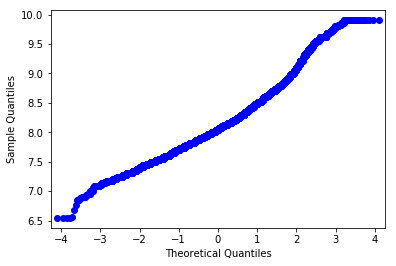

In [19]:
sm.qqplot(price_log, loc=price_log.mean(), scale=price_log.std())

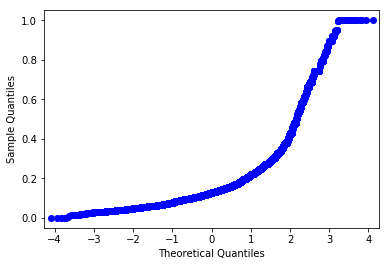

In [20]:
sm.qqplot(price_mm, loc=price_mm.mean(), scale=price_mm.std())

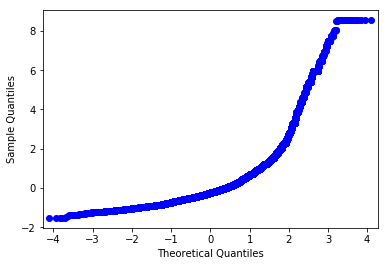

In [21]:
sm.qqplot(price_z, loc=price_z.mean(), scale=price_z.std())

## Feature selection

In [30]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification

X, y = make_classification()
X.shape, \
VarianceThreshold(.8).fit_transform(X).shape, \
VarianceThreshold(.9).fit_transform(X).shape

((100, 20), (100, 17), (100, 15))

In [36]:
from sklearn.feature_selection import SelectKBest, f_classif

X_kbest = SelectKBest(f_classif, k=5).fit_transform(X, y)

X_var = VarianceThreshold(.9).fit_transform(X)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

cross_val_score(LogisticRegression(), X, y, scoring='neg_log_loss').mean(), \
cross_val_score(LogisticRegression(), X_kbest, y, scoring='neg_log_loss').mean(), \
cross_val_score(LogisticRegression(), X_var, y, scoring='neg_log_loss').mean()

(-0.29572223854618129, -0.24020088103929593, -0.27965653275339603)

In [40]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

x_data_generated, y_data_generated = make_classification()
#print(x_data_generated.shape)
#print(SelectFromModel(estimator=RandomForestClassifier()).fit_transform(x_data_generated, y_data_generated).shape)
pipe = make_pipeline(SelectFromModel(estimator=RandomForestClassifier()), LogisticRegression())
lr = LogisticRegression()
rf = RandomForestClassifier()

print(cross_val_score(lr, x_data_generated, y_data_generated, scoring='neg_log_loss').mean())
print(cross_val_score(rf, x_data_generated, y_data_generated, scoring='neg_log_loss').mean())
print(cross_val_score(pipe, x_data_generated, y_data_generated, scoring='neg_log_loss').mean())

-0.40261818468
-0.622523801439
-0.25589944991


In [45]:
from mlxtend.feature_selection import SequentialFeatureSelector

selector = SequentialFeatureSelector(
    LogisticRegression(), scoring='neg_log_loss', verbose=2, k_features=3, forward=False, n_jobs=-1)
x_data_generated, y_data_generated = make_classification()
selector.fit(x_data_generated, y_data_generated)

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished

[2018-03-21 13:43:00] Features: 19/3 -- score: -0.376116688628[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.1s finished

[2018-03-21 13:43:00] Features: 18/3 -- score: -0.342780421113[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.1s finished

[2018-03-21 13:43:00] Features: 17/3 -- score: -0.316936274688[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.1s finished

[2018-03-21 13:43:01] Features: 16/3 -- score: -0.301737455148[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.1s finished

[2018-03-21 13:43:01] Features: 15/3 -- score: -0.291288992741[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished

[2018-03-21 13:43:01] Features: 14/3 -- score: -0.282572531278[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 ou

SequentialFeatureSelector(clone_estimator=True, cv=5,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             floating=False, forward=False, k_features=3, n_jobs=-1,
             pre_dispatch='2*n_jobs', scoring='neg_log_loss', verbose=2)